In [17]:
from IPython.display import Image

# BASIC SETUP

In [1]:
# FEATURES
#  - Save spatial relationship between pixels by learning 
#   internal feature representations using small squares of input data.
#  - fast training even for large data.
#
# USE IN IMAGE RECOGNITION
#  - Images of difference sizes.
#  - Images shifted, changed in orientation and position.
# 
# COMPONENTS
#  - Convolutional layers (filters + feature maps).
#  - Pooling layers.
#  - Fully-connected layers.

### MNIST DATASET

In [ ]:
# DATA INFO
#  Size: 60,000 in training, 10,000 in testing.
#  Images: 28 x 28 (784 pixels total).

15302656/15296311 [==============================] - 25s    


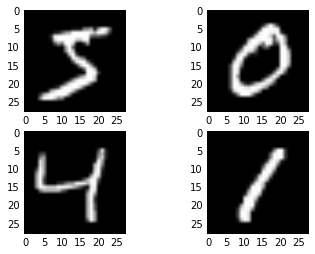

In [3]:
# LOAD & DEMO DATA
#  4 grayscale images.
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()
plt.subplot(221)
    #       ^^^
    #       |||
    # nrow, ncol, fig_idx.
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
plt.show()

#### A. MLP BASELINE

In [4]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils # for 1-hot coding.

In [5]:
# SET SEED & LOAD DATA
seed = 7
np.random.seed(seed)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
# VECTORIZATION (3D DATA -> VECTORS)
#  Dimensions: idx, image width, image height.
num_pixels = X_train.shape[1] * X_train.shape[2]
    #                      ^                  ^
    #                      |                  |
    #                   image width    idx  image height
    #                                   |
    #                                   v
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [7]:
# NORMALIZATION (0-255 -> 0-1)
X_train = X_train / 255
X_test = X_test / 255

In [9]:
# ONE-HOT ENCODING
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [13]:
# MODEL BUILDING
#  input 784 -> hidden [784] -> output 10
def baseline_model():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, init='normal', activation='relu'))
    model.add(Dense(num_classes, init='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [14]:
%%time
# MODEL FITTING
model = baseline_model()
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)
    # verbose: 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
scores = model.evaluate(X_test, y_test, verbose=0)
print "Baseline Error: %.2f%%" % (100 - scores[1]*100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
3s - loss: 0.2791 - acc: 0.9203 - val_loss: 0.1420 - val_acc: 0.9579
Epoch 2/10
3s - loss: 0.1122 - acc: 0.9679 - val_loss: 0.0991 - val_acc: 0.9699
Epoch 3/10
3s - loss: 0.0724 - acc: 0.9789 - val_loss: 0.0788 - val_acc: 0.9742
Epoch 4/10
3s - loss: 0.0509 - acc: 0.9853 - val_loss: 0.0776 - val_acc: 0.9770
Epoch 5/10
3s - loss: 0.0364 - acc: 0.9898 - val_loss: 0.0627 - val_acc: 0.9795
Epoch 6/10
3s - loss: 0.0264 - acc: 0.9931 - val_loss: 0.0639 - val_acc: 0.9797
Epoch 7/10
3s - loss: 0.0186 - acc: 0.9957 - val_loss: 0.0603 - val_acc: 0.9804
Epoch 8/10
3s - loss: 0.0147 - acc: 0.9968 - val_loss: 0.0619 - val_acc: 0.9815
Epoch 9/10
3s - loss: 0.0105 - acc: 0.9981 - val_loss: 0.0601 - val_acc: 0.9815
Epoch 10/10
3s - loss: 0.0072 - acc: 0.9989 - val_loss: 0.0608 - val_acc: 0.9816
Baseline Error: 1.84%
CPU times: user 1min 34s, sys: 2.29 s, total: 1min 36s
Wall time: 36.8 s


#### B. SIMPLE CONVOLUTIONAL NETS

In [15]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [16]:
# LOAD DATA & PREPROCESSING
seed = 7
np.random.seed(seed)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    #                             ^         ^   ^   ^
    #                             |         |   |   |
    #                            idx    channel wd ht
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
X_train = X_train / 255
X_test = X_test / 255
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [20]:
# MODEL BUILDING
#  conv [32,5,5] -> maxpool [2,2] -> dropout [.2] --flatten--> fnn_input [128] -> output [10].
def simple_convolutional():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, border_mode='valid', input_shape=(1,28,28), activation='relu'))
        # convolution size: 32 feature map (5 x 5). 
        # border_mode: 'valid'=no padding; 'same'=padding s.t. input fmap size = output fmap size.
    model.add(MaxPooling2D(pool_size=(2, 2)))
        # 2 x 2 pool-sample window.
    model.add(Dropout(.2))
    model.add(Flatten()) # ready for regular FNN post-processing.
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

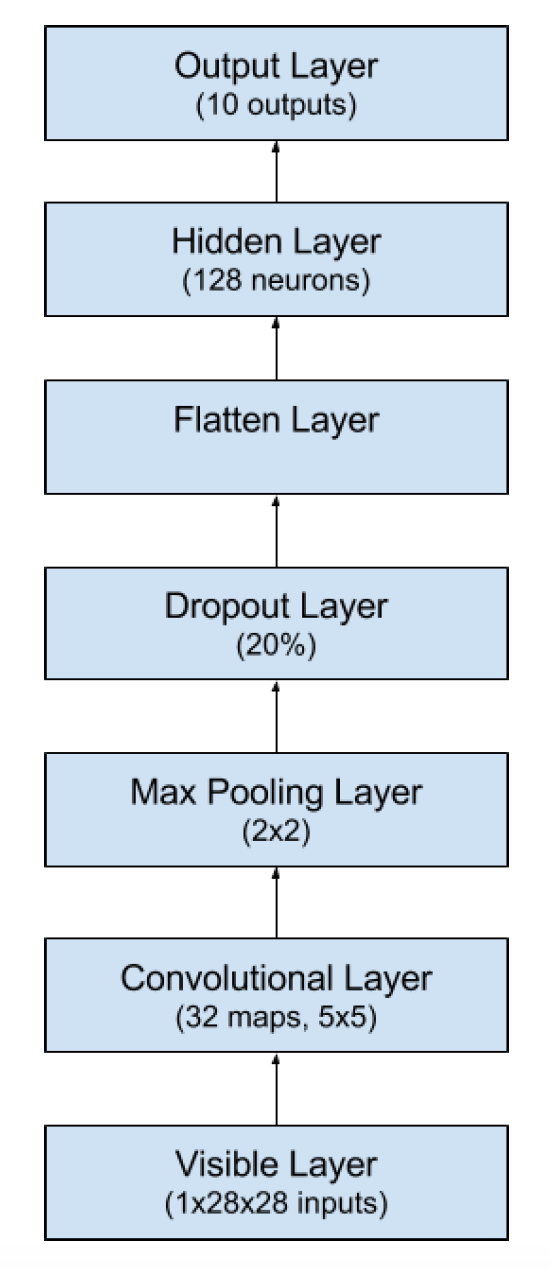

In [19]:
Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/DEEP_LEARNING/DATA/simple_conv_net.png', 
      width="20%")

In [21]:
%%time
# MODEL FITTING
model = simple_convolutional()
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print "Baseline Error: %.2f%%" % (100 - scores[1]*100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
40s - loss: 0.2065 - acc: 0.9369 - val_loss: 0.0757 - val_acc: 0.9756
Epoch 2/10
38s - loss: 0.0643 - acc: 0.9804 - val_loss: 0.0464 - val_acc: 0.9834
Epoch 3/10
41s - loss: 0.0446 - acc: 0.9865 - val_loss: 0.0386 - val_acc: 0.9885
Epoch 4/10
40s - loss: 0.0347 - acc: 0.9890 - val_loss: 0.0364 - val_acc: 0.9879
Epoch 5/10
40s - loss: 0.0269 - acc: 0.9914 - val_loss: 0.0334 - val_acc: 0.9895
Epoch 6/10
41s - loss: 0.0211 - acc: 0.9935 - val_loss: 0.0387 - val_acc: 0.9876
Epoch 7/10
40s - loss: 0.0185 - acc: 0.9943 - val_loss: 0.0324 - val_acc: 0.9892
Epoch 8/10
40s - loss: 0.0140 - acc: 0.9954 - val_loss: 0.0319 - val_acc: 0.9907
Epoch 9/10
40s - loss: 0.0118 - acc: 0.9962 - val_loss: 0.0356 - val_acc: 0.9899
Epoch 10/10
40s - loss: 0.0106 - acc: 0.9966 - val_loss: 0.0337 - val_acc: 0.9895
Baseline Error: 1.05%
CPU times: user 7min 57s, sys: 49.6 s, total: 8min 46s
Wall time: 7min 8s


#### C. LARGE CONVOLUTIONAL NETS

In [22]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [23]:
# LOAD DATA & PREPROCESSING
seed = 7
np.random.seed(seed)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
X_train = X_train / 255
X_test = X_test / 255
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [26]:
# MODEL BUILDING
#  conv [32,5,5] -> maxpool [2,2] -> conv [15,3,3] -> maxpool [2,2] ->
#   dropout [.2] --flatten--> fnn_input [128] -> fnn_hidden [50] -> output [10].
def large_convolutional():
    model = Sequential()
    model.add(Convolution2D(30, 5, 5, border_mode='valid', input_shape=(1,28,28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

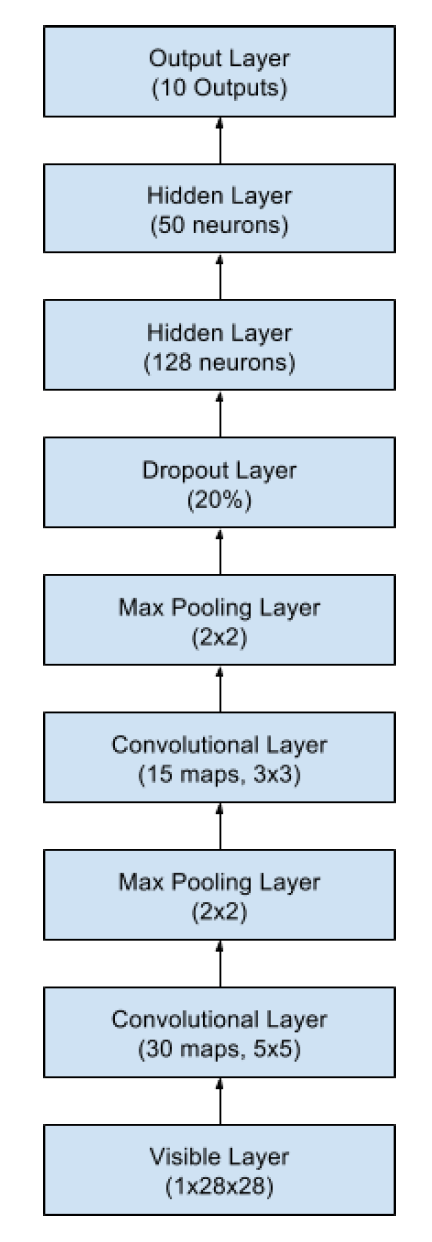

In [24]:
Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/DEEP_LEARNING/DATA/large_conv_net.png', 
      width="20%")

In [27]:
%%time
# MODEL FITTING
model = large_convolutional()
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print "Baseline Error: %.2f%%" % (100 - scores[1]*100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
44s - loss: 0.3265 - acc: 0.8961 - val_loss: 0.0699 - val_acc: 0.9781
Epoch 2/10
44s - loss: 0.0857 - acc: 0.9733 - val_loss: 0.0436 - val_acc: 0.9864
Epoch 3/10
45s - loss: 0.0629 - acc: 0.9804 - val_loss: 0.0376 - val_acc: 0.9876
Epoch 4/10
44s - loss: 0.0508 - acc: 0.9836 - val_loss: 0.0337 - val_acc: 0.9894
Epoch 5/10
44s - loss: 0.0446 - acc: 0.9857 - val_loss: 0.0364 - val_acc: 0.9887
Epoch 6/10
44s - loss: 0.0394 - acc: 0.9877 - val_loss: 0.0294 - val_acc: 0.9901
Epoch 7/10
44s - loss: 0.0337 - acc: 0.9895 - val_loss: 0.0246 - val_acc: 0.9914
Epoch 8/10
44s - loss: 0.0301 - acc: 0.9902 - val_loss: 0.0238 - val_acc: 0.9924
Epoch 9/10
44s - loss: 0.0294 - acc: 0.9903 - val_loss: 0.0210 - val_acc: 0.9929
Epoch 10/10
44s - loss: 0.0269 - acc: 0.9911 - val_loss: 0.0287 - val_acc: 0.9904
Baseline Error: 0.96%
CPU times: user 7min 28s, sys: 1min 9s, total: 8min 37s
Wall time: 7min 33s


# CNN TUNING

In [28]:
# CONTENT
#  - Image augmentation.
#  - Sample & feature standardization.
#  - ZCA.
#  - Random rotations, shifts, flips.
#  - I/O.

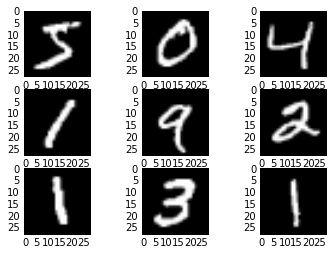

In [29]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()
for i in range(0, 9): # 3 x 3 grid of images
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

### SAMPLE STANDARDIZATION

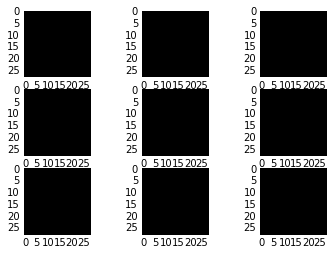

In [33]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=True, 
                             featurewise_std_normalization=False, samplewise_std_normalization=True)
    # standardize data/samples, but not features.
datagen.fit(X_train) # fit parameters from data.
datagen.flow(X_train, y_train, batch_size=9) # configure batch size.
X_batch, y_batch = datagen.next()
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

### FEATURE STANDARDIZATION

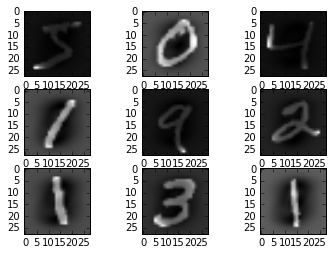

In [34]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen.fit(X_train) 
datagen.flow(X_train, y_train, batch_size=9)
X_batch, y_batch = datagen.next()
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

### ZCA WHITENING

In [ ]:
# ZCA (Zero-phase Component Analysis, Bell and Sejnowski 1996)
#  Purpose: retain the features of the original as much as possible.
#  Link: http://stats.stackexchange.com/questions/117427/what-is-the-difference-between-zca-whitening-and-pca-whitening.
#  Feature: "local" transformation (vs. PCA's "global" transformation).

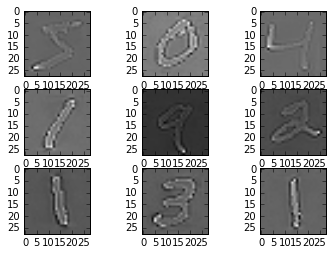

In [36]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, zca_whitening=True)
datagen.fit(X_train) 
datagen.flow(X_train, y_train, batch_size=9) 
X_batch, y_batch = datagen.next()
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

### RANDOM ROTATIONS

In [ ]:
# Purpose: learning from varying rotated images in training.

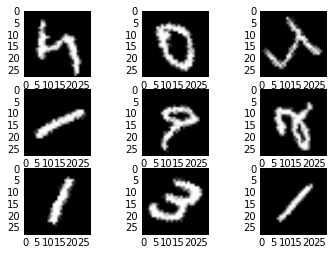

In [37]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, rotation_range=90)
    # up to 90-degrees in random rotations.
datagen.fit(X_train) 
datagen.flow(X_train, y_train, batch_size=9) 
X_batch, y_batch = datagen.next()
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

### RANDOM SHIFTS

In [ ]:
# Purpose: learning from off-center images in training.

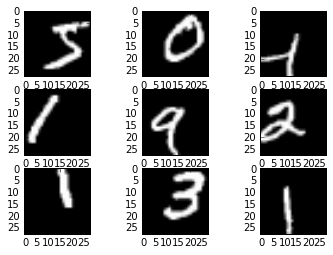

In [42]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False,
                             width_shift_range=.3, height_shift_range=.3)
    # up-down, left-right shift in 10% of image measures.
datagen.fit(X_train) 
datagen.flow(X_train, y_train, batch_size=9) 
X_batch, y_batch = datagen.next()
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

### RANDOM FLIPS

In [43]:
# Purpose: learning from flips of images on vertical/horizontal axis in training.

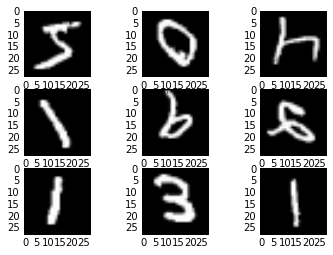

In [44]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
datagen = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(X_train) 
datagen.flow(X_train, y_train, batch_size=9) 
X_batch, y_batch = datagen.next()
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

### I/O

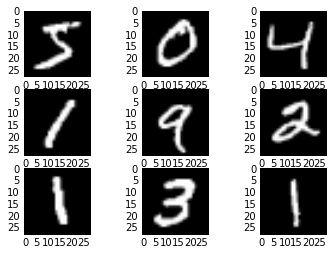

In [45]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
datagen = ImageDataGenerator()
datagen.fit(X_train) 
# import os
# os.mkdirs(..)
path = '/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/DEEP_LEARNING/DATA/'
datagen.flow(X_train, y_train, batch_size=9, save_to_dir=path, save_prefix='aug', save_format='png') 
X_batch, y_batch = datagen.next()
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

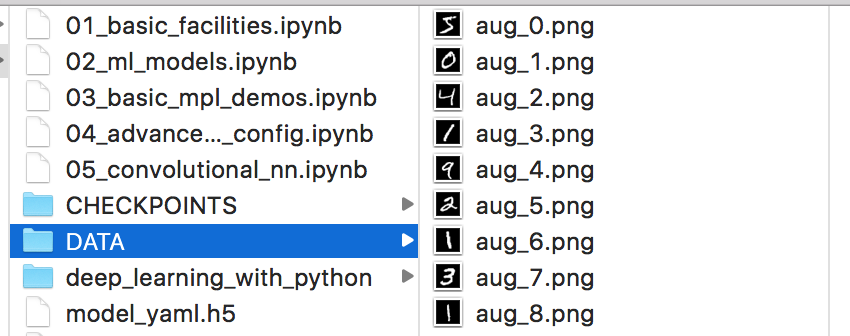

In [48]:
Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/DEEP_LEARNING/DATA/aug_image_save.png', 
      width="35%")

# DEMO 1: OBJECT RECOGNITION

In [ ]:
# DATA: CIFAR-10
#  - 60,000 photos divided into 10 classes.
#  - 32 x 32 in rgb.

170500096/170498071 [==============================] - 286s   
Untaring file...


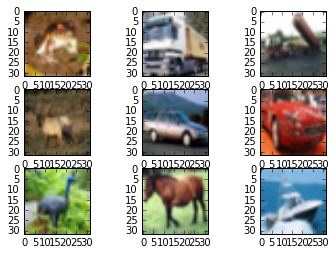

In [49]:
# LOAD & DEMO DATA
from keras.datasets import cifar10
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import toimage
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(toimage(X_train[i]))
plt.show()

### SIMPLE CNN
**2HRS TO TRAIN**

In [50]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [56]:
# LOAD & PREPROCESSING DATA
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train.astype('float32') / 255., X_test.astype('float32') / 255.
y_train, y_test = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [57]:
# MODEL BUILDING
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), border_mode='same', 
                        activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same', W_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.5))
model.add(Dense(num_classes, activation='softmax'))
epochs = 25
lrate = .01
decay = lrate / epochs
sgd = SGD(lr=lrate, momentum=.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_6 (Convolution2D)    (None, 32, 32, 32)  896         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
dropout_5 (Dropout)                (None, 32, 32, 32)  0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)    (None, 32, 32, 32)  9248        dropout_5[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)      (None, 32, 16, 16)  0           convolution2d_7[0][0]            
___________________________________________________________________________________________

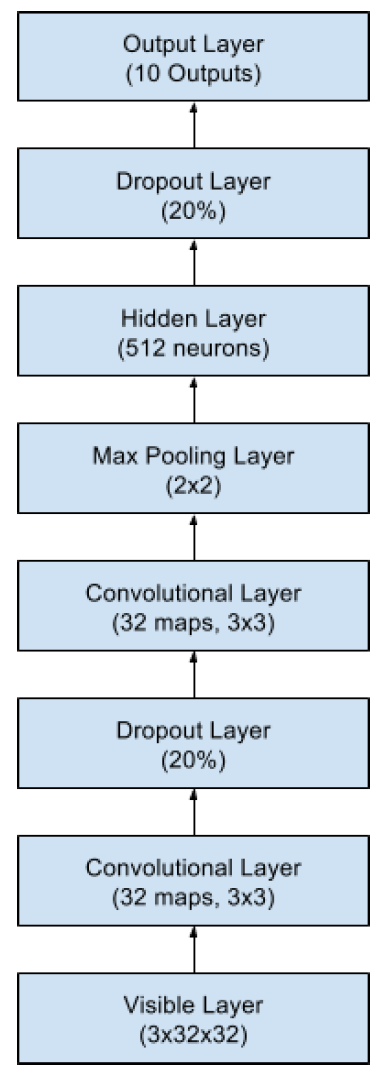

In [58]:
Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/DEEP_LEARNING/DATA/obj_simple_conv_net.png', 
      width="20%")

In [59]:
%%time
# MODEL RUNNING & EVALUATION
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=32)
scores = model.evaluate(X_test, y_test, verbose=0)
print "Accuracy: %.2f%%" % (scores[1]*100)

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 296s - loss: 1.6133 - acc: 0.4140 - val_loss: 1.3328 - val_acc: 0.5305
Epoch 2/25
50000/50000 [==============================] - 293s - loss: 1.2382 - acc: 0.5585 - val_loss: 1.0979 - val_acc: 0.6164
Epoch 3/25
50000/50000 [==============================] - 291s - loss: 1.0751 - acc: 0.6190 - val_loss: 1.0308 - val_acc: 0.6323
Epoch 4/25
50000/50000 [==============================] - 292s - loss: 0.9515 - acc: 0.6654 - val_loss: 0.9693 - val_acc: 0.6613
Epoch 5/25
50000/50000 [==============================] - 284s - loss: 0.8567 - acc: 0.6993 - val_loss: 0.9460 - val_acc: 0.6696
Epoch 6/25
50000/50000 [==============================] - 286s - loss: 0.7744 - acc: 0.7281 - val_loss: 0.9059 - val_acc: 0.6862
Epoch 7/25
50000/50000 [==============================] - 285s - loss: 0.7033 - acc: 0.7519 - val_loss: 0.8882 - val_acc: 0.6944
Epoch 8/25
50000/50000 [=======================

### LARGE CNN

**WARNING: THIS RUNS SLOW AS HELL ON CPU**

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

In [ ]:
# LOAD & PREPROCESSING DATA
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train.astype('float32') / 255., X_test.astype('float32') / 255.
y_train, y_test = np_utils.to_categorical(y_train), np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [ ]:
# MODEL BUILDING
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), border_mode='same', activation='relu'))
model.add(Dropout(.2))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(Dropout(.2))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(Dropout(.2))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(.2))
model.add(Dense(num_classes, activation='softmax'))
epochs = 25
lrate = .01
decay = lrate / epochs
sgd = SGD(lr=lrate, momentum=.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print model.summary()

In [ ]:
%%time
# MODEL RUNNING & EVALUATION
np.random.seed(seed)
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)
print "Accuracy: %.2f%%" % (scores[1]*100)

# DEMO 2: SENTIMENT ANALYSIS

In [60]:
# DATA: STANFORD IMDB SENTIMENT DATA
#  - 25,000 movie reviews.
#  - words replaced by intergers that indicate the Absolute Popularity of Word.

33218560/33213513 [==============================] - 55s    
Training data: 
(25000,)
(25000,)
Classes: 
[0 1]
Number of words: 
24902
Review length: 
Mean 285.84 words (212.622320)


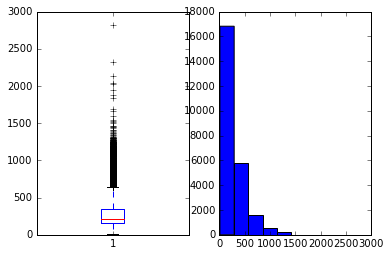

In [62]:
# LOAD & DEMO DATA
import numpy as np
from keras.datasets import imdb
import matplotlib.pyplot as plt
%matplotlib inline
(X_train, y_train), (X_test, y_test) = imdb.load_data(test_split=0) # load all to train for demo.
print "Training data: "
print X_train.shape
print y_train.shape
print "Classes: "
print np.unique(y_train)
print "Number of words: "
print len(np.unique(X_train))
print "Review length: "
result = map(len, X_train)
print "Mean %.2f words (%f)" % (np.mean(result), np.std(result))
plt.subplot(121)
plt.boxplot(result)
plt.subplot(122)
plt.hist(result)
plt.show()

### MLP BASELINE

In [67]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [68]:
# LOAD DATA
seed = 7
np.random.seed(seed)
top_words = 5000 # we only care about top 5000 most frequent words.
test_split = .33
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, test_split=test_split)
max_words = 500 # truncate/pad reviews to a standardize size of 500 words.
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [70]:
# MODEL BUILDING
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words)) # words -> 32D vectors.
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
embedding_1 (Embedding)            (None, 500, 32)     160000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_5 (Flatten)                (None, 16000)       0           embedding_1[0][0]                
____________________________________________________________________________________________________
dense_12 (Dense)                   (None, 250)         4000250     flatten_5[0][0]                  
____________________________________________________________________________________________________
dense_13 (Dense)                   (None, 1)           251         dense_12[0][0]                   
Total params: 4160501
_____________________________________________________________________

In [71]:
%%time
# MODEL RUNNING & EVALUATION
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=1)
    # low epoch size to avoid overfitting.
scores = model.evaluate(X_test, y_test, verbose=0)
print "Accuracy: %.2f%%" % (scores[1]*100)

Train on 16750 samples, validate on 8250 samples
Epoch 1/2
16750/16750 [==============================] - 12s - loss: 0.5616 - acc: 0.6785 - val_loss: 0.3420 - val_acc: 0.8573
Epoch 2/2
16750/16750 [==============================] - 12s - loss: 0.2027 - acc: 0.9219 - val_loss: 0.3299 - val_acc: 0.8627
Accuracy: 86.27%
CPU times: user 54.7 s, sys: 4.52 s, total: 59.2 s
Wall time: 33 s


### 1D CNN

In [72]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.preprocessing import sequence

In [73]:
# LOAD DATA
seed = 7
np.random.seed(seed)
top_words = 5000 # we only care about top 5000 most frequent words.
test_split = .33
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, test_split=test_split)
max_words = 500 # truncate/pad reviews to a standardize size of 500 words.
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [74]:
# MODEL BUIDLING
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same', activation='relu'))
    # 32 feature maps, 3 vector elements per time.
model.add(MaxPooling1D(pool_length=2)) # length, stride = 2, halves the size the fmaps from conv. layer.
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
embedding_2 (Embedding)            (None, 500, 32)     160000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 500, 32)     3104        embedding_2[0][0]                
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)      (None, 250, 32)     0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
flatten_6 (Flatten)                (None, 8000)        0           maxpooling1d_1[0][0]             
___________________________________________________________________________________________

In [76]:
%%time
# MODEL RUNNING & EVALUATION
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print "Accuracy: %.2f%%" % (scores[1]*100)

Train on 16750 samples, validate on 8250 samples
Epoch 1/2
16750/16750 [==============================] - 33s - loss: 0.1687 - acc: 0.9344 - val_loss: 0.3184 - val_acc: 0.8743
Epoch 2/2
16750/16750 [==============================] - 33s - loss: 0.1213 - acc: 0.9568 - val_loss: 0.3639 - val_acc: 0.8699
Accuracy: 86.99%
CPU times: user 1min 23s, sys: 9.18 s, total: 1min 32s
Wall time: 1min 10s
